In [1]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
import numpy as np
from sklearn import preprocessing
import matplotlib.pyplot as plt

In [0]:
x_train = np.memmap('drive/My Drive/Xtrain.dat', shape=(600000, 2351), dtype=np.float32)
y_train = np.memmap('drive/My Drive/Ytrain.dat', dtype=np.float32)
# 0 for benign (nb of elm => 300000)
# 1 for malicious (nb of elm => 300000)

In [4]:
# dimension reduction
print(x_train.shape)
x_train = np.delete(x_train, np.s_[-47:], axis=1)
print(x_train.shape)

(600000, 2351)
(600000, 2304)


In [0]:
# normalize data for printing (pixels range: [0, 255])
min_max_scaler = preprocessing.MinMaxScaler((0, 255), copy=False)
x_train = min_max_scaler.fit_transform(x_train)

In [0]:
# reshape the data to consider vectors as images
x_train = np.reshape(x_train, (600000, 48, 48))

In [0]:
x_train = x_train / 255.0

In [0]:
# define the classes
classes = ['benign', 'malicious']

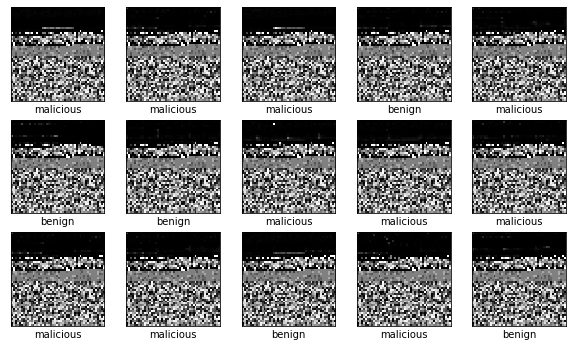

In [9]:
# graphical representation of the malwares
plt.figure(figsize=(10,10))
cpt = 1
for i in range(50000, 50015):
  plt.subplot(5, 5, cpt)
  plt.xticks([])
  plt.yticks([])
  plt.grid(False)
  plt.imshow(x_train[i], cmap='gray')
  plt.xlabel(classes[int(y_train[i])])
  cpt += 1
plt.show()

In [0]:
# reshpe for CNN
x_train = np.reshape(x_train, (600000, 48, 48, 1))

In [11]:
# split the data into two parts (training set and test set)
x_train, x_test = x_train[:550000], x_train[550000:]
y_train, y_test = y_train[:550000], y_train[550000:]

print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)

(550000, 48, 48, 1)
(550000,)
(50000, 48, 48, 1)
(50000,)


In [0]:
from keras.models import Sequential, Model, load_model
from keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Input, UpSampling2D, normalization
from keras import optimizers

In [0]:
# link our layers

# input 48 x 48 x 1 
input_vect = Input(shape=(48, 48, 1))

# encoder

# block 1
encoder = Conv2D(8, (3, 3), activation='relu', padding='same') (input_vect)
norm = normalization.BatchNormalization() (encoder)
block1 = MaxPooling2D(pool_size=(2, 2)) (norm)

# block 2
encoder = Conv2D(16, (3,3), activation='relu', padding='same') (block1)
block2 = normalization.BatchNormalization() (encoder)

# decoder

# block 3
decoder = Conv2D(8, (3, 3), activation='relu', padding='same') (block2)
norm = normalization.BatchNormalization() (decoder)
block3 = UpSampling2D((2, 2)) (norm)

# block 4 (reconstruct the input)
out_vect = Conv2D(1, (3, 3), activation='sigmoid', padding='same') (block3)

In [0]:
# create our model
autoencoder = Model(input_vect, out_vect)

In [20]:
autoencoder.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 48, 48, 1)         0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 48, 48, 8)         80        
_________________________________________________________________
batch_normalization_4 (Batch (None, 48, 48, 8)         32        
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 24, 24, 8)         0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 24, 24, 16)        1168      
_________________________________________________________________
batch_normalization_5 (Batch (None, 24, 24, 16)        64        
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 24, 24, 8)         1160

In [0]:
# compile our model
autoencoder.compile(loss="mean_squared_error", optimizer='adam')

In [22]:
# fit our autoencoder
h1 = autoencoder.fit(x_train, x_train, validation_split=0.2, epochs=10, batch_size=256)

Train on 440000 samples, validate on 110000 samples
Epoch 1/10
440000/440000 [==============================] - 26s 60us/step - loss: 0.0164 - val_loss: 0.0061
Epoch 2/10
440000/440000 [==============================] - 26s 59us/step - loss: 0.0048 - val_loss: 0.0044
Epoch 3/10
440000/440000 [==============================] - 26s 59us/step - loss: 0.0040 - val_loss: 0.0039
Epoch 4/10
440000/440000 [==============================] - 26s 59us/step - loss: 0.0037 - val_loss: 0.0036
Epoch 5/10
440000/440000 [==============================] - 26s 60us/step - loss: 0.0035 - val_loss: 0.0035
Epoch 6/10
440000/440000 [==============================] - 26s 59us/step - loss: 0.0034 - val_loss: 0.0033
Epoch 7/10
440000/440000 [==============================] - 26s 59us/step - loss: 0.0032 - val_loss: 0.0032
Epoch 8/10
440000/440000 [==============================] - 26s 60us/step - loss: 0.0031 - val_loss: 0.0031
Epoch 9/10
440000/440000 [==============================] - 26s 60us/step - loss: 0.

In [0]:
# create the model after autoencoder training

input_l = Flatten() (out_vect)
hidden = Dense(400, activation='relu') (input_l)
l_end = Dense(1, activation='sigmoid') (hidden)

# full model
model = Model(input_vect, l_end)

In [24]:
model.summary()

Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 48, 48, 1)         0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 48, 48, 8)         80        
_________________________________________________________________
batch_normalization_4 (Batch (None, 48, 48, 8)         32        
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 24, 24, 8)         0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 24, 24, 16)        1168      
_________________________________________________________________
batch_normalization_5 (Batch (None, 24, 24, 16)        64        
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 24, 24, 8)         1160

In [0]:
# compile our model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [26]:
# fit our model
history = model.fit(x_train, y_train, validation_split=0.2, epochs=4, shuffle=True)

440000/440000 [==============================] - 98s 223us/step - loss: 0.1494 - acc: 0.9405 - val_loss: 0.0980 - val_acc: 0.9665
Epoch 2/4
440000/440000 [==============================] - 95s 215us/step - loss: 0.0871 - acc: 0.9677 - val_loss: 0.1062 - val_acc: 0.9539
Epoch 3/4
440000/440000 [==============================] - 95s 216us/step - loss: 0.0698 - acc: 0.9743 - val_loss: 0.0763 - val_acc: 0.9723
Epoch 4/4
440000/440000 [==============================] - 95s 215us/step - loss: 0.0597 - acc: 0.9783 - val_loss: 0.0588 - val_acc: 0.9773


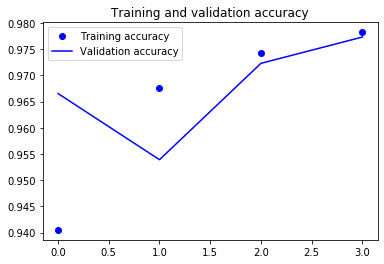

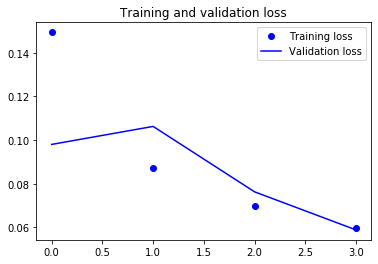

In [28]:
# plot accuracy of the model

accuracy = history.history['acc']
val_accuracy = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(len(accuracy))
plt.plot(epochs, accuracy, 'bo', label='Training accuracy')
plt.plot(epochs, val_accuracy, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

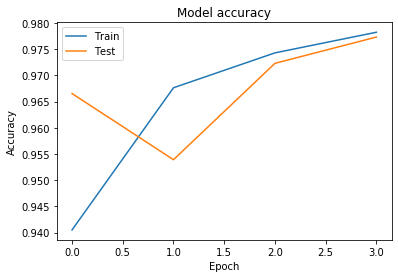

In [30]:
# evaluate the training

plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [0]:
# save the model
model.save('drive/My Drive/models_save/cnn_autoencoder.h5')

In [0]:
# load the model
model_ = load_model('drive/My Drive/models_save/cnn_autoencoder.h5')

In [33]:
# evaluate our model
loss, acc = model_.evaluate(x_test, y_test, verbose=2)

print("loss: " + str(loss))
print("acc: " + str(acc))

loss: 0.03939984729360789
acc: 0.98504
